### Contextualização:

Um estudo foi conduzido para investigar a influência dos aspectos culturais na propensão à corrupção, focando no comportamento dos diplomatas em relação ao estacionamento nas proximidades da sede das Nações Unidas, localizada em Manhattan, Nova York. Até 2002, a imunidade diplomática isentava os diplomatas da ONU de penalidades relacionadas a infrações de estacionamento, limitando as consequências de suas ações às normas culturais vigentes. No entanto, a partir de 2002, as autoridades passaram a ter o direito de confiscar as placas diplomáticas dos infratores, alterando assim o regime de aplicação das penas. Como resultado, as infrações de estacionamento não pagas diminuíram drasticamente. Aqueles que costumavam estacionar de forma irregular passaram a evitar essa prática, enquanto aqueles que já respeitavam as regras de estacionamento continuaram a fazê-lo.
- Rereferência:
     - Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement: Evidence From  Diplomatic Parking Ticket
     - Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
     - Disponível em: https://www.journals.uchicago.edu/doi/abs/10.1086/527495


**Perguntas**:

1. Qual seria a quantidade média esperada de violações de trânsito para um país cujo corpo diplomático seja composto por X1 membros, considerando o período anterior à vigência da lei e cujo índice de corrupção seja igual a X2?

2. Qual seria a quantidade média esperada de violações de trânsito para o mesmo país, porém agora considerando a vigência da lei?

Para isso, serão construídos **Modelos de Regressão para Dados de Contagem**: <span style="font-family:Comic Sans MS; color:red">**modelo preditivo Poisson**</span> e <span style="font-family:Comic Sans MS; color:red">**modelo preditivo Binomial Negativo**</span>.
- Por que utilizar **Modelos de Regressão para Dados de Contagem**?
  - O objetivo aqui é analisar o comportamento de determinada <span style="font-family:Comic Sans MS; color:blue">**variável dependente**</span> (comumente chamada de Y), em função de <span style="font-family:Comic Sans MS; color:red">**variáveis preditoras**</span> (comumente chamadas de X). A **variável dependente** esperada é da forma <span style="font-family:Comic Sans MS; color:brown">**quantitativa**</span>, com <span style="font-family:Comic Sans MS; color:purple">**valores discretos**</span>, <span style="font-family:Comic Sans MS; color:lime">**não negativos**</span>, <span style="font-family:Comic Sans MS; color:pink">**para uma determinada exposição**</span>.

In [6]:
# Instalação dos pacotes

!pip install pandas
!pip install numpy
!pip install -U seaborn
!pip install matplotlib
!pip install plotly
!pip install scipy
!pip install statsmodels
!pip install scikit-learn
!pip install statstests

In [13]:
# Importação dos pacotes

import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from math import exp, factorial # funções matemáticas 'exp' e 'factorial'
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação de modelos de contagem
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson
# pacote acima para a estimação dos modelos ZINB e ZIP, respectivamente
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
# pacote anterior para a realização do teste de Vuong
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos

import warnings
warnings.filterwarnings('ignore')

<div style="text-align: center;">
     <strong<p align="center">REGRESSÃO PARA DADOS DE CONTAGEM</po</strong>
</div>


In [14]:
# CARREGAMENTO DA BASE DE DADOS 'corruption'
df_corruption = pd.read_csv('corruption.csv', delimiter=',')

labels = '''
VARIÁVEIS:      
"violation" é a variável Y (contagem): quantidade de violações de trânsito. É uma variável quantitativa, discreta(inteiro), não negativa(inclui o zero) e para dada exposição (por mês)                                             
"post": "no" antes do enforcement legal                                   
"post": "yes" após o enforcement legal                                    
"staf": corpo diplomático                                                 
"corruption": indicador de corrupção. Índice da transparência Internacional. Quanto maior o índice, pior é a classificação do país.  
'''
print(labels)
print(df_corruption)


VARIÁVEIS:      
"violation" é a variável Y (contagem): quantidade de violações de trânsito. É uma variável quantitativa, discreta(inteiro), não negativa(inclui o zero) e para dada exposição (por mês)                                             
"post": "no" antes do enforcement legal                                   
"post": "yes" após o enforcement legal                                    
"staf": corpo diplomático                                                 
"corruption": indicador de corrupção. Índice da transparência Internacional. Quanto maior o índice, pior é a classificação do país.  

                  country code  violations  staff post  corruption
0                  Angola  AGO          50      9   no    1.047506
1                  Angola  AGO           1      9  yes    1.047506
2                 Albania  ALB          17      3   no    0.921079
3                 Albania  ALB           0      3  yes    0.921079
4    United Arab Emirates  ARE           0      3   no   -

In [15]:
# Características das variáveis do dataset
df_corruption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     298 non-null    object 
 1   code        298 non-null    object 
 2   violations  298 non-null    int64  
 3   staff       298 non-null    int64  
 4   post        298 non-null    object 
 5   corruption  298 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 14.1+ KB


In [16]:
# Estatísticas univariadas
df_corruption.describe()

,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [17]:
# Tabela de frequências da variável dependente 'violations'
# Função 'values_counts' do pacote 'pandas', sem e com o argumento 'normalize=True', para gerar as contagens e os percentuais, respectivamente

contagem = df_corruption['violations'].value_counts(dropna=False)
percent = (df_corruption['violations'].value_counts(dropna=False, normalize=True)*100).round(2)
table = pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=True)
table

,contagem,%
violations,,
0,156,52.35
1,35,11.74
2,16,5.37
3,17,5.70
4,5,1.68
5,10,3.36
6,3,1.01
7,4,1.34
8,3,1.01


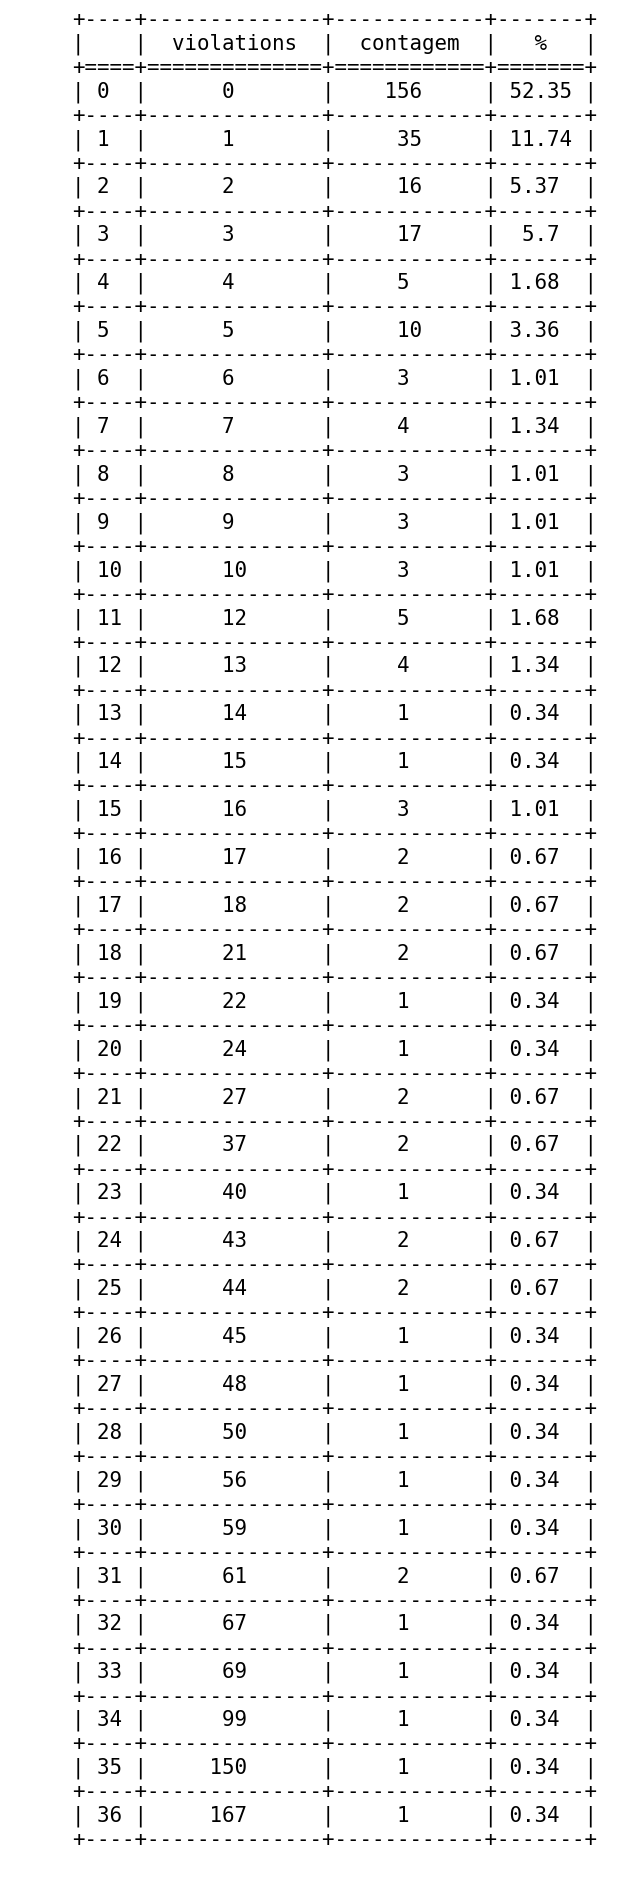

In [18]:
# Visualização da tabela de frequências da variável dependente 'violations' no ambiente Plots

table.reset_index(level=0, inplace=True)
table.rename(columns={'index': 'n'}, inplace=True)

from tabulate import tabulate
tabela = tabulate(table, headers='keys', tablefmt='grid', numalign='center')

plt.figure(figsize=(8, 3))
plt.text(0.1, 0.1, tabela, {'family': 'monospace', 'size': 15})
plt.axis('off')
plt.show()